In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.transforms import Normalize
# from collections import namedtuple

#importing Technical Analysis tools
from ta import trend
from ta import volatility
from ta import momentum

from utils import return_fun

In [2]:
torch.cuda.is_available()

True

In [3]:
sx5e_data=pd.read_csv("data\SX5E.csv")

In [4]:
sx5e_data.head()

,Date,Open,High,Low,Close
0,12/10/21,4198.18,4221.57,4178.66,4199.16
1,12/09/21,4242.66,4246.52,4201.85,4208.30
2,12/08/21,4273.32,4288.20,4233.09,4233.09
3,12/07/21,4157.72,4277.03,4157.72,4276.20
4,12/06/21,4095.39,4146.16,4078.64,4137.11


In [5]:
sx5e_data = sx5e_data.sort_index(axis=0 ,ascending=False)
sx5e_data.reset_index(drop=True,inplace=True)
sx5e_data.drop(columns=['Date'],inplace=True)

# sx5e_data['Return']=ret_fun
sx5e_data.dropna(inplace=True)


adi=trend.ADXIndicator(close=sx5e_data[' Close'],high=sx5e_data[' High'],low=sx5e_data[' Low'])
m_acd=trend.MACD(close=sx5e_data[' Close'])

r_si=momentum.RSIIndicator(close=sx5e_data[' Close'])
stochastic_oscilator=momentum.StochasticOscillator(close=sx5e_data[' Close'],high=sx5e_data[' High'],low=sx5e_data[' Low'])
williamsr=momentum.WilliamsRIndicator(high=sx5e_data[' High'],low=sx5e_data[' Low'],close=sx5e_data[' Close'])

bollinger=volatility.BollingerBands(close=sx5e_data[' Close'])
atr=volatility.AverageTrueRange(high=sx5e_data[' High'],low=sx5e_data[' Low'],close=sx5e_data[' Close'])

exponential_moving_avarge9=trend.EMAIndicator(close=sx5e_data[' Close'],window=9)
exponential_moving_avarge18=trend.EMAIndicator(close=sx5e_data[' Close'],window=18)
exponential_moving_avarge30=trend.EMAIndicator(close=sx5e_data[' Close'],window=30)

sx5e_data['ADX']=adi.adx()
sx5e_data['MACD']=m_acd.macd()
sx5e_data['RSI']=r_si.rsi()
sx5e_data['Stoch Osc']=stochastic_oscilator.stoch()
sx5e_data['Williams R']=williamsr.williams_r()
sx5e_data['Bollinger High band']=bollinger.bollinger_hband()
sx5e_data['Bolinger Low Band']=bollinger.bollinger_lband()
sx5e_data['ATR']=atr.average_true_range()
sx5e_data['EMA9']=exponential_moving_avarge9.ema_indicator()
sx5e_data['EMA18']=exponential_moving_avarge18.ema_indicator()
sx5e_data['EMA30']=exponential_moving_avarge30.ema_indicator()
sx5e_data.dropna(inplace=True)
ret_fun=return_fun(sx5e_data,1,3)

C:\Users\aczer\AppData\Local\Programs\Python\Python39\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\aczer\AppData\Local\Programs\Python\Python39\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


In [6]:
type(ret_fun[1])
# tensor_return=torch.Tensor(ret_fun)
print(len(ret_fun))
ret_fun.remove(None)
print(len(ret_fun))
tensor_ret=torch.tensor(ret_fun,dtype=torch.float32)
print(tensor_ret)

3077
3076
tensor([-0.2160,  0.3504,  1.3764,  ..., -1.0081, -0.5856, -0.2172])


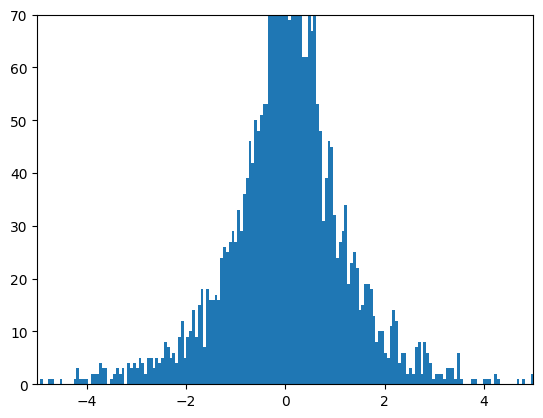

In [7]:
x=ret_fun
plt.hist(x, bins=400)
plt.ylim(0,70)
plt.xlim(-5,5)
plt.show()

In [8]:
sx5e_data.drop(sx5e_data.tail(1).index,inplace=True)
sx5e_tensor=torch.tensor(sx5e_data.values)

In [9]:
sx5e_data=torch.tensor(sx5e_data.values,dtype=torch.float32)

In [10]:
mean=torch.mean(sx5e_tensor,dim=0)
std=torch.std(sx5e_tensor,dim=0)
sx5e_norm=(sx5e_tensor-mean)/std
# print(sx5e_norm)

In [14]:
train=sx5e_norm[998:]

val=sx5e_norm[499:998]
test=sx5e_norm[:499]
print(train.shape)
print(val.shape)
print(test.shape)

# print(train[2077])
# print(val[498])
# print(test[0])

torch.Size([2078, 15])
torch.Size([499, 15])
torch.Size([499, 15])


In [18]:
mean_ret=torch.mean(tensor_ret)
std_ret=torch.std(tensor_ret)
ret_norm=(tensor_ret-mean_ret)/std_ret
print(ret_norm)

tensor([-0.1859,  0.2549,  1.0534,  ..., -0.8024, -0.4736, -0.1868])


In [19]:
train_target=ret_norm[998:]
val_target=ret_norm[499:998]
test_target=ret_norm[:499]

print(train_target.type)
print(val_target.shape)
print(test_target.shape)

<built-in method type of Tensor object at 0x00000257935ACD60>
torch.Size([499])
torch.Size([499])


In [15]:
data=namedtuple('Data',['x','target'])
prediction_days=5
days_to_predict=1
dataset=[]
for i in range(len(sx5e_norm)-2):
    end = i + prediction_days
    out_end = end + days_to_predict

    if(out_end>len(sx5e_norm)):
        break
    
    
    X=(sx5e_norm[i:end])
    y=(tensor_ret[end])
    d=data(X,y)
    dataset.append(d)
    

In [16]:
# print(len(dataset))

train_set=dataset[998:]
val_set=dataset[499:998]
test_set=dataset[:499]

print(len(train_set))
print(len(val_set))
print(len(test_set))

2073
499
499


In [27]:
train_loader=torch.utils.data.DataLoader(train_set, batch_size=128)
val_loader=torch.utils.data.DataLoader(val_set, batch_size=64)
test_loader=torch.utils.data.DataLoader(test_set, batch_size=64)

In [23]:
from utils import correct

In [19]:
from utils import LSTMNumeric

In [30]:

lstm_numeric=LSTMNumeric(15,30).cuda()
params = lstm_numeric.parameters()
# for name, param in lstm_numeric.named_parameters():
#     if param.requires_grad:
#         print(param.data) 
        
loss_fn=torch.nn.MSELoss()
optimizer = torch.optim.Adam(params, lr=0.06) 
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
# we will train for only a single epoch 
epoch = 75


history_train_loss=[]
history_val_loss=[]
history_train_acc=[]

# main loop
for e in range(1,epoch+1):
    
    train_losses=[]
    train_acc=[]
    loss_buffer=[]
    running_loss=0
    corr=0
    size=0
    
    lstm_numeric.train()
    
    for i, (x, y) in enumerate(train_loader):
        size+=len(y)
        x=x.float()
        y=y.float()
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        
        output = lstm_numeric(x)

        loss = loss_fn(output, y)
        corr+=correct(output,y,std_ret,mean_ret)
        loss_buffer.append(loss.item())
        loss.backward()
        optimizer.step() 
        
    
    scheduler.step()
    
    train_loss=torch.mean(torch.tensor(loss_buffer))
    history_train_loss.append(train_loss)
    train_acc=corr/size
    print()
    print(f"Epoch:  {e}  Train Loss:  {train_loss:.3f} Train Acc: {train_acc:.5f}")
    
    lstm_numeric.eval()

    with torch.no_grad():
        val_loss_buffer=[]
        val_ac=0
        size=0
        cor=0
        for i, (x,y) in enumerate(val_loader):
            x=x.float()
            y=y.float()
            
            x=x.cuda()
            y=y.cuda()
            
            output=lstm_numeric(x)
            val_loss_buffer.append(loss_fn(output,y).item())
            cor+=correct(output,y,std_ret,mean_ret)
            size+=len(y)
        val_acc=cor/size
        val_loss=torch.mean(torch.tensor(val_loss_buffer))
        print(f"Val loss: {val_loss:.3f} Val Acc {val_acc:.5f}")
        print()
        
        history_val_loss.append(val_loss)


Epoch:  1  Train Loss:  2.879 Train Acc: 0.48963
Val loss: 1.357 Val Acc 0.47295


Epoch:  2  Train Loss:  1.785 Train Acc: 0.49686
Val loss: 1.509 Val Acc 0.52705


Epoch:  3  Train Loss:  1.582 Train Acc: 0.51712
Val loss: 1.327 Val Acc 0.52705


Epoch:  4  Train Loss:  1.512 Train Acc: 0.52822
Val loss: 1.327 Val Acc 0.52705


Epoch:  5  Train Loss:  1.508 Train Acc: 0.51230
Val loss: 1.341 Val Acc 0.52705


Epoch:  6  Train Loss:  1.515 Train Acc: 0.50989
Val loss: 1.354 Val Acc 0.52705


Epoch:  7  Train Loss:  1.523 Train Acc: 0.50796
Val loss: 1.349 Val Acc 0.52705


Epoch:  8  Train Loss:  1.524 Train Acc: 0.50844
Val loss: 1.337 Val Acc 0.52705


Epoch:  9  Train Loss:  1.522 Train Acc: 0.50796
Val loss: 1.331 Val Acc 0.52705


Epoch:  10  Train Loss:  1.520 Train Acc: 0.50844
Val loss: 1.331 Val Acc 0.52705


Epoch:  11  Train Loss:  1.518 Train Acc: 0.51037
Val loss: 1.330 Val Acc 0.52705


Epoch:  12  Train Loss:  1.516 Train Acc: 0.50796
Val loss: 1.331 Val Acc 0.52705




In [31]:
torch.save(lstm_numeric,'models/lstm_numeric')

In [11]:
from utils import TimeSeriesTransformer

In [12]:
## Model parameters
dim_val = 512 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 8 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_decoder_layers = 4 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
input_size = 15 # The number of input variables. 1 if univariate forecasting.
dec_seq_len = 14 # length of input given to decoder. Can have any integer value.
enc_seq_len = 10 # length of input given to encoder. Can have any integer value.
output_sequence_length = 10 # Length of the target sequence, i.e. how many time steps should your forecast cover
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make the positional encoder

model = TimeSeriesTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    dec_seq_len=dec_seq_len,
    batch_first = True,
    # max_seq_len=max_seq_len,
    out_seq_len=output_sequence_length, 
    n_decoder_layers=n_decoder_layers, 
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads)

In [13]:
sx5e_norm.shape

torch.Size([3076, 15])

In [14]:
test=sx5e_norm[0:24]

In [15]:
test.shape

torch.Size([24, 15])

In [16]:
test.unsqueeze(0).shape

torch.Size([1, 24, 15])

In [17]:
src, trg, trg_y = model.get_src_trg(test,14,10)

In [18]:
trg_y

tensor([-0.7650, -0.7331, -0.6851, -0.5532, -0.5626, -0.5715, -0.5332, -0.5259,
        -0.5366, -0.5574], dtype=torch.float64)

In [19]:
output = model(src.unsqueeze(0),trg.unsqueeze(0))

From model.forward(): Size of src as given to forward(): torch.Size([1, 14, 15])
From model.forward(): tgt size = torch.Size([1, 10, 1])
From model.forward(): Size of src after input layer: torch.Size([1, 14, 512])
From model.forward(): Size of src after pos_enc layer: torch.Size([1, 14, 512])
From model.forward(): Size of src after encoder: torch.Size([1, 14, 512])
From model.forward(): Size of decoder_output after linear decoder layer: torch.Size([1, 10, 512])
From model.forward(): decoder_output shape after decoder: torch.Size([1, 10, 512])
From model.forward(): decoder_output size after linear_mapping = torch.Size([1, 10, 1])


In [20]:
output.shape

torch.Size([1, 10, 1])